In [116]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import xrd
import helpers as h
import model_common
from importlib import reload

reload(xrd)
reload(model_common)
reload(h)

<module 'helpers' from '/Users/vekeryk/Projects/master-project-light/helpers.py'>

In [117]:
# Paths
EXPERIMENT_FILE = "experiments/experiment.txt"

# MODEL_CHECKPOINT = 'checkpoints/target_model.pt'
# MODEL_CHECKPOINT = 'checkpoints/target_model_2.pt'
MODEL_CHECKPOINT = 'checkpoints/100000_log_best_params.pt'
# MODEL_CHECKPOINT = 'checkpoints/100000_log_best_curve.pt'

# Device
device = model_common.get_device()
print(f"Using device: {device}")

✓ Using MPS (Apple Silicon)
Using device: mps


In [118]:
def load_experimental_data(file_path):
    intensities = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            # Split by arrow if present
            if '→' in line:
                _, value = line.split('→')
            else:
                value = line
            
            # Replace comma with dot for European format
            value = value.replace(',', '.')
            
            try:
                intensities.append(float(value))
            except ValueError:
                print(f"Warning: Could not parse line: {line}")
                continue
    
    return np.array(intensities)


# Load data
exp_data = load_experimental_data(EXPERIMENT_FILE)
print(f"✅ Loaded {len(exp_data)} data points from {EXPERIMENT_FILE}")

✅ Loaded 360 data points from experiments/experiment.txt


In [119]:
def pad_tail_like_noise(curve, target_L=800, k=20, jitter=0.03, seed=None):
    rng = np.random.default_rng(seed)
    N = len(curve)
    if N >= target_L: return curve[:target_L]
    tail = curve[-k:]
    mu, sigma = tail.mean(), tail.std(ddof=1)
    n_pad = target_L - N
    noise = rng.normal(mu, sigma * jitter, size=n_pad)
    return np.concatenate([curve, noise]).astype(curve.dtype)

In [120]:
exp_data = model_common.preprocess_curve(exp_data)

In [121]:
true_params = [0.008094, 0.000943, 5200e-8, 3500e-8, 0.00255, 3000e-8, -50e-8]
simulated_curve, simulated_profile = xrd.compute_curve_and_profile(
    array=true_params,
    dl=100e-8,
    instrumental=True
)
# simulated_curve.Y_R_vseZ = model_common.preprocess_curve(simulated_curve.Y_R_vseZ)

/var/folders/jk/xsnyxvks5ts_232t26nlcr400000gn/T/ipykernel_3806/2972817922.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.semilogy(simulated_curve.Y_R_vseZ, 'b-', linewidth=1.5, label='Simulated data', color='orange')


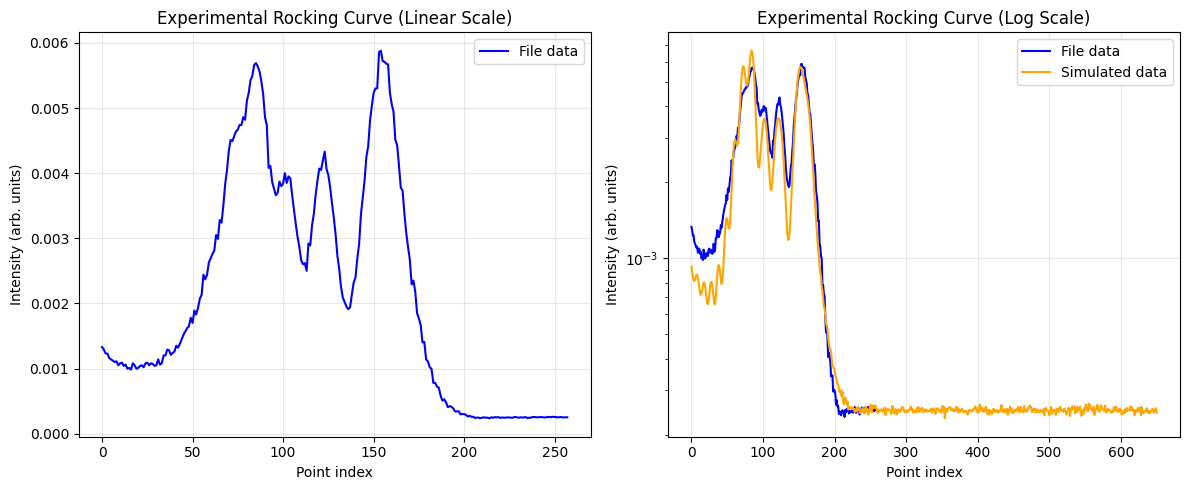

Peak position: index 154
Peak intensity: 5.8800e-03
Truncation point (start_ML): 50
Points used for ML: 208 (will be interpolated to 650)


In [122]:
plt.figure(figsize=(12, 5))

# Linear scale
plt.subplot(1, 2, 1)
plt.plot(exp_data, 'b-', linewidth=1.5, label='File data')
# plt.plot(r_curve.Y_R_vseZ, 'b-', linewidth=1.5, label='Full data', color='orange')
plt.xlabel('Point index')
plt.ylabel('Intensity (arb. units)')
plt.title('Experimental Rocking Curve (Linear Scale)')
plt.grid(True, alpha=0.3)
plt.legend()

# Log scale
plt.subplot(1, 2, 2)
plt.semilogy(exp_data, 'b-', linewidth=1.5, label='File data')
plt.semilogy(simulated_curve.Y_R_vseZ, 'b-', linewidth=1.5, label='Simulated data', color='orange')
plt.xlabel('Point index')
plt.ylabel('Intensity (arb. units)')
# plt.xlim(150, 400)
plt.title('Experimental Rocking Curve (Log Scale)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

peak_idx = np.argmax(exp_data)
print(f"Peak position: index {peak_idx}")
print(f"Peak intensity: {exp_data.max():.4e}")
print(f"Truncation point (start_ML): 50")
print(f"Points used for ML: {len(exp_data) - 50} (will be interpolated to 650)")

In [123]:
# fig, axes = plt.subplots(1, 2, figsize=(12, 4)) # 12 width, 4 height

# axes[0].set_title("Simulated Rocking Curve")
# axes[0].plot(simulated_curve.X_DeltaTeta, simulated_curve.Y_R_vseZ, label="Simulated Rocking Curve")
# axes[0].set_yscale("log")
# axes[0].grid(True)
# axes[0].legend()

# axes[1].set_title("Simulated Deformation Profile")
# axes[1].plot(simulated_profile.X, simulated_profile.total_Y, label="Total Profile")
# axes[1].plot(simulated_profile.X, simulated_profile.asymmetric_Y, label="Asymmetric Profile")
# axes[1].plot(simulated_profile.X, simulated_profile.decaying_Y, label="Decaying Profile")
# axes[1].grid(True)
# axes[1].legend()

# plt.tight_layout()
# plt.show()

In [124]:
def preprocess_for_model(
    data: np.ndarray,
    truncate_point: int = 0,
    max_length: int = 650,
    torch_dtype: torch.dtype = torch.float32
) -> torch.Tensor:
    n = len(data)
    print(f"Total data points: {n}")
    if n <= truncate_point:
        raise ValueError(f"Data too short! Has {n} points, need at least {truncate_point+1}")

    # Use float64 in NumPy to avoid precision loss during slicing/padding/printing
    tail = np.asarray(data[truncate_point:], dtype=np.float64)
    print(f"After skipping first {truncate_point} points: {len(tail)} points remaining")

    if len(tail) == max_length:
        processed = tail
        print(f"✅ Exact match: {max_length} points")
    elif len(tail) > max_length:
        processed = tail[:max_length]
        print(f"Truncated from {len(tail)} to {max_length} points")
    else:
        # Remain unchanged (model will handle variable length)
        # processed = tail

        pad_right = max_length - len(tail)
        processed = np.pad(tail, (0, pad_right), mode='constant', constant_values=2.05e-04)
        print(f"Padded on right with {pad_right} zeros → {processed.shape}")

    print("First 10 of processed data (scientific, 8 sig figs):")
    print(np.array2string(processed[:10], formatter={'float_kind': lambda x: f"{x:.8e}"}))

    t = torch.from_numpy(processed).to(dtype=torch_dtype)
    return t


x_length = simulated_curve.Y_R_vseZ.shape[0]
experiment_Y = preprocess_for_model(exp_data, max_length=x_length)

# if CONVERT_TO_MODAL:
#     # Preprocess experimental data
#     experiment_Y_original = experiment_Y.clone()
#     x_length = experiment_Y.size()[0]

#     experiment_Y_copy = experiment_Y.numpy()
#     experiment_last = 190
#     simulated_first = 190
#     experiment_Y_new = np.concat([
#         experiment_Y_copy[:experiment_last], 
#         simulated_curve.Y_R_vseZ[40:701][simulated_first:x_length-(experiment_last-simulated_first)]
#     ])
#     experiment_Y = torch.from_numpy(experiment_Y_new).to(dtype=torch.float32)

# print(f"\n✅ Preprocessed data shape: {experiment_Y.shape}")
# print(f"Data range after normalization: {experiment_Y.min():.4f} to {experiment_Y.max():.4f}")

Total data points: 258
After skipping first 0 points: 258 points remaining
Padded on right with 393 zeros → (651,)
First 10 of processed data (scientific, 8 sig figs):
[1.33000000e-03 1.29000000e-03 1.23000000e-03 1.23000000e-03
 1.16000000e-03 1.14000000e-03 1.12000000e-03 1.10000000e-03
 1.11000000e-03 1.05000000e-03]


In [125]:
print(experiment_Y[:10].numpy())
print(experiment_Y[-10:].numpy())
print(experiment_Y.size())

[0.00133 0.00129 0.00123 0.00123 0.00116 0.00114 0.00112 0.0011  0.00111
 0.00105]
[0.000205 0.000205 0.000205 0.000205 0.000205 0.000205 0.000205 0.000205
 0.000205 0.000205]
torch.Size([651])


## 4. Load Trained Model

In [126]:
# Load model checkpoint
if not Path(MODEL_CHECKPOINT).exists():
    raise FileNotFoundError(f"Model checkpoint not found: {MODEL_CHECKPOINT}")

checkpoint = torch.load(MODEL_CHECKPOINT, map_location=device)
print(f"Checkpoint contains: {list(checkpoint.keys())}")

# Initialize model
model = model_common.XRDRegressor().to(device)
# model.load_state_dict(checkpoint['model'])
state_dict = checkpoint["model"]
if "hann_window" in state_dict:
    print(
        "   Note: Removing hann_window from checkpoint (will be recreated dynamically)")
    state_dict.pop("hann_window")

model.load_state_dict(state_dict, strict=False)
model.eval()

print(f"✅ Loaded checkpoint from {MODEL_CHECKPOINT}")

Checkpoint contains: ['model', 'L', 'epoch', 'val_loss_params', 'val_loss_curve']
   Note: Removing hann_window from checkpoint (will be recreated dynamically)
✅ Loaded checkpoint from checkpoints/100000_log_best_params.pt


## 5. Make Predictions

In [127]:
print(f"Input data length for model: {x_length} points")
model_X = torch.tensor(np.linspace(0, x_length - 1, x_length)).unsqueeze(0)
model_Y = experiment_Y.unsqueeze(0)

log_space = True
# if '_log_' in MODEL_CHECKPOINT:
#     log_space = True
#     print("Using log space for normalization")

batch_size = 32
# batch_size = 128

test_model_Y = torch.tensor(simulated_curve.Y_R_vseZ, dtype=torch.float32).unsqueeze(0)

ds = model_common.NormalizedXRDDataset(model_X, test_model_Y, train=False, log_space=log_space)
# ds = model_common.NormalizedXRDDataset(model_X, model_Y, train=False, log_space=log_space)

dl = torch.utils.data.DataLoader(ds, batch_size=batch_size)

# X, Y = model_common.load_dataset(Path("datasets/dataset_10000_dl100_targeted.pkl"))
# # Create dataset
# ds = model_common.NormalizedXRDDataset(X[0:1], Y[0:1], log_space=True, train=False)
# dl = torch.utils.data.DataLoader(ds, batch_size=batch_size)

preds = []
with torch.no_grad():
    for y, _ in dl:
        p = model(y.to(device))
        preds.append(p.to(device))
P = torch.cat(preds, dim=0)
Theta_hat = model_common.denorm_params(P)

Input data length for model: 651 points


In [128]:
test_model_Y.size()

torch.Size([1, 651])

In [129]:
model_Y.size()

torch.Size([1, 651])

In [130]:
true_params

[0.008094, 0.000943, 5.2e-05, 3.5e-05, 0.00255, 3e-05, -5e-07]

In [131]:
preds

[tensor([[0.2030, 0.0138, 0.6311, 0.6570, 0.0623, 0.8016, 0.9830]],
        device='mps:0')]

In [132]:
pred_values = Theta_hat[0]
pred_values.cpu().numpy()

array([ 7.0896624e-03,  9.1447507e-04,  4.6022302e-05,  3.3349075e-05,
        2.8686132e-03,  4.1071879e-05, -1.1067459e-06], dtype=float32)

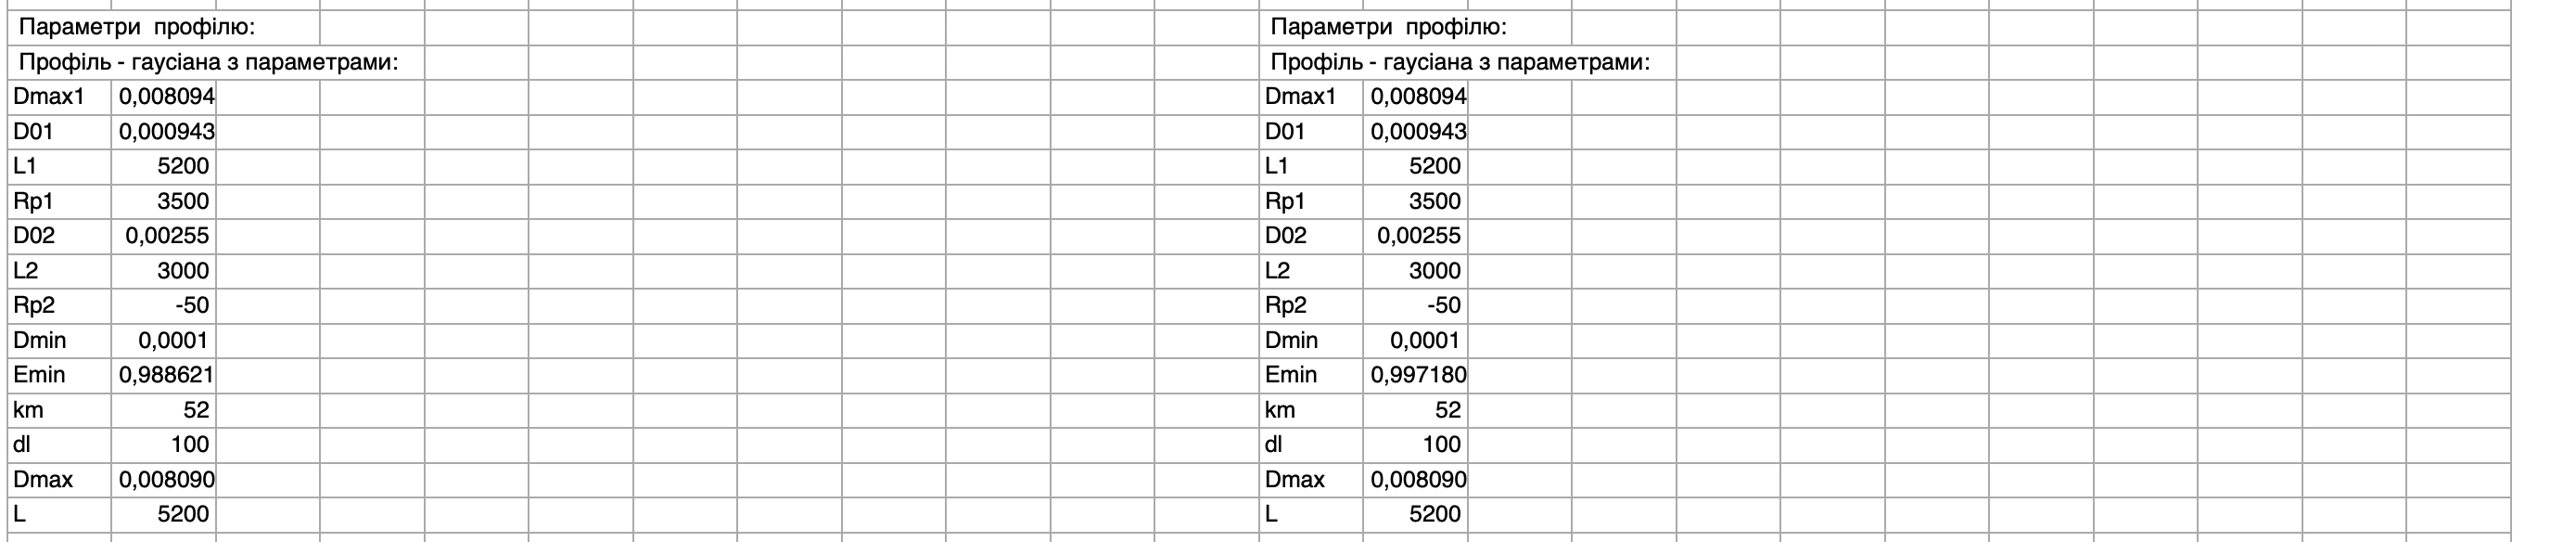

In [133]:
model_Y.numpy()[0][:10]

array([0.00133, 0.00129, 0.00123, 0.00123, 0.00116, 0.00114, 0.00112,
       0.0011 , 0.00111, 0.00105], dtype=float32)

In [134]:
simulated_curve.ML_Y[:10]

array([0.00092517, 0.00088202, 0.00084244, 0.00081713, 0.00081147,
       0.00082317, 0.00084295, 0.00085822, 0.00085819, 0.00083833])

In [135]:
predicted_curve, predicted_profile = xrd.compute_curve_and_profile(
    array=pred_values.tolist(),
    dl=100e-8,
    instrumental=True
)

In [136]:
x = torch.linspace(0, x_length - 1, x_length)

In [137]:
predicted_curve.Y_R_vseZ[:20]

array([0.00074783, 0.00070511, 0.0006769 , 0.00066811, 0.00067745,
       0.0006978 , 0.00071844, 0.00072866, 0.00072131, 0.0006953 ,
       0.00065603, 0.00061368, 0.00057993, 0.00056403, 0.00056965,
       0.00059353, 0.00062639, 0.00065579, 0.00067023, 0.00066289])

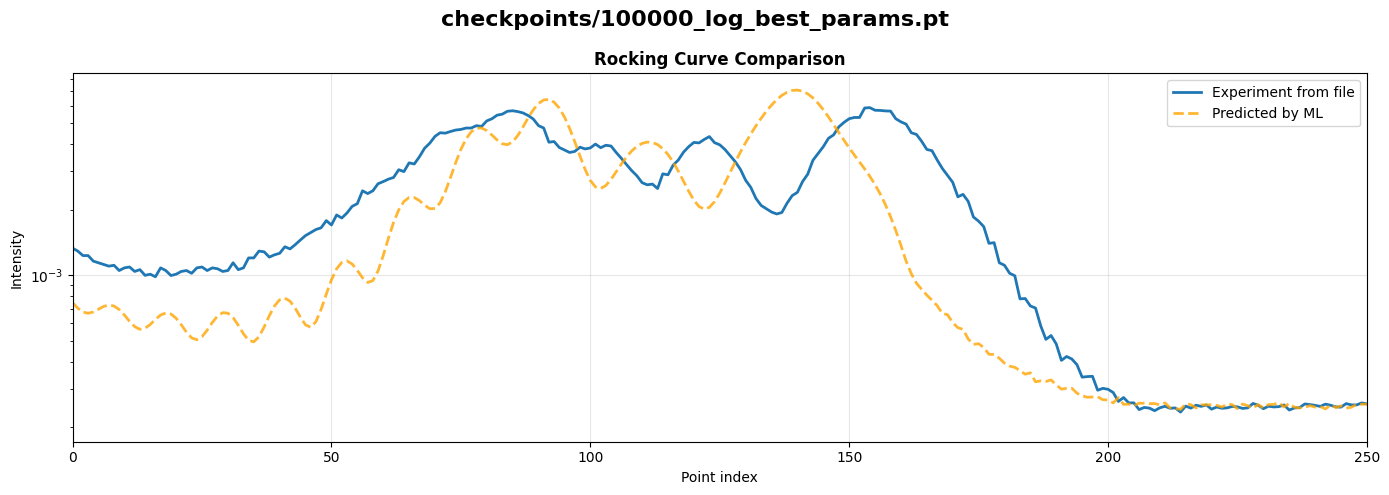

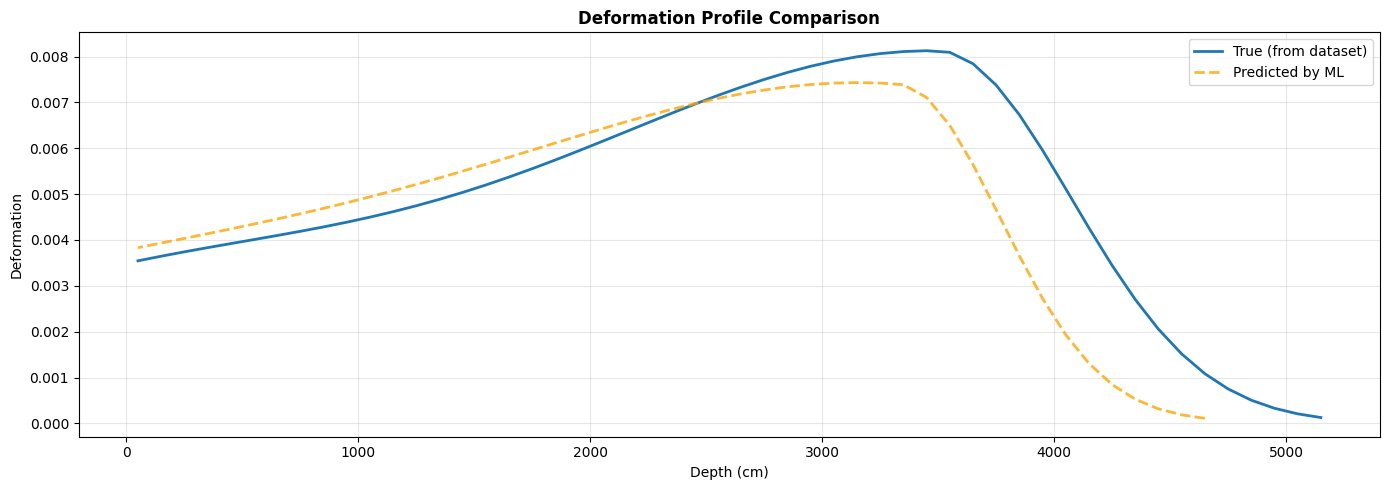

Input data length for model: 651 points


In [138]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))

fig.suptitle(MODEL_CHECKPOINT, fontsize=16, fontweight='bold')

# Rocking Curve
ax.set_title("Rocking Curve Comparison", fontsize=12, fontweight='bold')
ax.plot(x, experiment_Y.numpy(), label="Experiment from file", color='C0', linestyle='-', linewidth=2)

# Predicted curve
ax.plot(x, predicted_curve.Y_R_vseZ, 
        label="Predicted by ML", color='orange', linestyle='--', linewidth=2, alpha=0.8)

# Simulated curve
# ax.plot(x, simulated_curve.Y_R_vseZ, 
#         label="SIMULATED CURVE", color='red', linestyle='--', linewidth=2, alpha=0.8)

ax.set_xlabel("Point index")
ax.set_xlim(0, 250)
ax.set_ylabel("Intensity")
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(14, 5))
# Deformation Profile
ax.set_title("Deformation Profile Comparison", fontsize=12, fontweight='bold')
ax.plot(simulated_profile.X, simulated_profile.total_Y, 
        label="True (from dataset)", color='C0', linestyle='-', linewidth=2)
ax.plot(predicted_profile.X, predicted_profile.total_Y, 
        label="Predicted by ML", color='orange', linestyle='--', linewidth=2, alpha=0.8)
ax.set_xlabel("Depth (cm)")
ax.set_ylabel("Deformation")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()
print(f"Input data length for model: {x_length} points")